## Object-Orienting programing:
Before we start I would like to review/talk about some object-oriented programming concepts.
These concepts will be usefull to understand the following code and they are present everywhere when we use datascience toolkits such as the well-known sklearn.

To learn about this concepts I suggest reading the following article: [How to explain object-oriented programming concepts to a 6-year-old](https://medium.freecodecamp.org/object-oriented-programming-concepts-21bb035f7260)

**Note:** If you are familiar with this concepts you can jump to the next section...

## Exercise:
Define a "dog" and "cat" classes with the following attributes:
- name (string)
- age  (integer)
- energy (integer initialized with the value 0)

And the following methods:
- eat: This method increments the energy level by 1.
- sleep: This method increments the energy level by 3.
- play: This method decrements the energy level by 5. If the object is a Cat this method should return the string "miau miau..." and, if the object is a Dog, this method should return "wauf wauf...."

Also, only for the Dog class, implement an extra method called "sit" that increments the energy level by 1.

<!---
solution:
class Animal():
    def __init__(self, name, age):
        self.name = name
        self.age = age
        self.energy = 0
    
    def eat(self):
        self.energy += 1
        
    def sleep(self):
        self.energy += 3
    
    def play(self):
        self.energy -= 5

class Dog(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("wauf wauf")

class Cat(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("miau miau")        
-->


In [17]:
## Implement your code here

In [18]:
# Dont delete this code... This should run after you have defined your classes.
dog_obj = Dog(name="gandalf", age=1)
cat_obj = Cat(name="python", age=1)

assert issubclass(type(dog_obj), Animal)
assert issubclass(type(cat_obj), Animal)
assert dog_obj.energy == 0
assert cat_obj.energy == 0

dog_obj.eat()
cat_obj.eat()
assert dog_obj.energy == 1
assert cat_obj.energy == 1

dog_obj.eat()
cat_obj.eat()
dog_obj.sleep()
cat_obj.sleep()
assert dog_obj.energy == 5
assert cat_obj.energy == 5

dog_obj.play()
cat_obj.play()
assert dog_obj.energy == 0
assert cat_obj.energy == 0

wauf wauf
miau miau


as you can observe the methods we defined change the internal state of the objects we have created without accessing to the energy attribute directly.

Also with this approach we can create lists of objects and call methods without knowing if those objects are dogs or cats.

In [19]:
animals = [Dog(name="gandalf", age=1), Cat(name="python", age=1)]

for animal in animals:
    animal.eat()

print (animals[0].energy)
print (animals[1].energy)

1
1


# Linear classifiers:

Now that we have seen the fundamental concepts behind Object-Oriented Programming we will implement from scratch a simple **Rosenblatt Perceptron** and a **Logistic Regression** classifier.


## Our Corpus:
In order to test our models we will use the "Twenty Newsgroups". Here is the official description, quoted from the [website](http://qwone.com/~jason/20Newsgroups/):

"_The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of our knowledge, it was originally collected by Ken Lang, probably for his paper “Newsweeder: Learning to filter netnews,” though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering._"

### Corpus Loading and Preprocessing:

For simplification we will only use 4 categories out of the 20 possible ones.

In [20]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [21]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [22]:
len(twenty_train.data), len(twenty_train.filenames)

(2034, 2034)

In [23]:
twenty_train.data[0]

"From: rych@festival.ed.ac.uk (R Hawkes)\nSubject: 3DS: Where did all the texture rules go?\nLines: 21\n\nHi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych\n\n======================================================================\nRycharde Hawkes\t\t\t\temail: rych@festival.ed.ac.uk\nVirtual Environment Laboratory\nDept. of Psychology\t\t\tTel  : +44 31 650 3426\nUniv. of Edinburgh\t\t\tFax  : +44 31 667 0150\n==============

In [24]:
twenty_train.target[0]

1

### Feature Extraction:


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(twenty_train.data).toarray()
Y = twenty_train.target
X.shape, Y.shape

((2034, 33811), (2034,))

Now that we have our data imported we can start working on our classifiers.

## Classifier Class:

Going back to our problem, the first thing to do is to define a common structure shared across the different Linear Classifiers. Note that they are similar in nature and for that reason they will have a lot in common.

Namely, both this algorithm share the following functions:
- **Train:** The train function receives a set of training features (X) and the corresponding labels (Y) and updates the model parameters over $n$ epochs.
- **Evaluate:** A function that computes the model accuracy with the current parameters.
- **plot_train:** A function to plot train/dev accuracy over epoch.
- **update_weights:** This is the function that is used to update the model weights.
- **predict:** Function used to make new predictions with the current model parameters.

The difference between the Logistic Regression and the Perceptron algorithm will lie in these last two functions and for that reason the classifier class does not implement them.


In [26]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np

class Classifier(object):
    """ Multi Class Classifier base class """

    def __init__(self, input_size, n_classes):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        self.parameters = np.zeros((input_size+1, n_classes)) # input_size +1 to include the Bias term

    def train(self, X, Y, devX, devY, epochs=20):
        """
        This trains the perceptron over a certain number of epoch and records the
            accuracy in Train and Dev sets along each epoch.
        :param X: numpy array with size DxN where D is the number of training examples
                 and N is the number of features.
        :param Y: numpy array with size D containing the correct labels for the training set
        :param devX (optional): same as X but for the dev set.
        :param devY (optional): same as Y but for the dev set.
        :param epochs (optional): number of epochs to run.
        """
        train_accuracy = [self.evaluate(X, Y)]
        dev_accuracy = [self.evaluate(devX, devY)]
        for epoch in range(epochs):
            for i in tqdm(range(X.shape[0])):
                self.update_weights(X[i, :], Y[i])
            train_accuracy.append(self.evaluate(X, Y))
            dev_accuracy.append(self.evaluate(devX, devY))
        return train_accuracy, dev_accuracy
        

    def evaluate(self, X, Y):
        """
        Evaluates the error in a given set of examples.
        :param X: numpy array with size DxN where D is the number of examples to 
                    evaluate and N is the number of features.
        :param Y: numpy array with size D containing the correct labels for the training set
        """
        correct_predictions = 0
        for i in range(X.shape[0]):
            y_pred = self.predict(X[i, :])
            if Y[i] == y_pred:
                correct_predictions += 1
        return correct_predictions/X.shape[0]


    def plot_train(self, train_accuracy, dev_accuracy):
        """
        Function to Plot the accuracy of the Training set and Dev set per epoch.
        :param train_accuracy: list containing the accuracies of the train set.
        :param dev_accuracy: list containing the accuracies of the dev set.
        """
        x_axis = [epoch+1 for epoch in range(len(train_accuracy))]
        plt.plot(x_axis, train_accuracy, '-g', linewidth=1, label='Train')
        plt.xlabel("epochs")
        plt.ylabel("Accuracy")
        plt.plot(x_axis, dev_accuracy, 'b-', linewidth=1, label='Dev')
        plt.legend()
        plt.show()


    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will 
            update the model parameters.
        
        :param x: Array of size N where N its the number of features that the model 
                  takes as input.
        :param y: The int corresponding to the correct label.
        
        child classes must implement this function
        """
        pass

    def predict(self, x):
        """
        This function will add a Bias value to the received input, multiply the Weights 
            corresponding to the different classeswith the input vector and choose the 
            class that maximizes that multiplication.
        
        :param x: numpy array with size 1xN where N = number of features.
        
        child classes must implement this function
        """
        pass

## Logistic Regression:
Since we have a multi-class classification problem we have to define a Multinomial Logistic Regression, which in other words is a Logistic Regression with a softmax function in the end.

<img src="images/multinomialLR.png" alt="Alt text that describes the graphic" title="Title text" />

When predicting with such model we want to compute:
<img src="images/LRargmax.png" alt="Alt text that describes the graphic" title="Title text" />

where Z_x is defined as:

<img src="images/LRZx.png" alt="Alt text that describes the graphic" title="Title text" />

#### But how can we learn W ??

We want to find a set of parameters $\hat{W}$ that for our training samples  $D = \{x_t, y_t\}_{t=1}^N$ maximize the following probability:

<img src="images/LRobjective1.png" alt="Alt text that describes the graphic" title="Title text" />

which is equivalent to minimizing:

<img src="images/LRobjective2.png" alt="Alt text that describes the graphic" title="Title text" />

According to the **gradient descent algorithm** our model parameters are updated according to the following update rule:



In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

class MultinomialLR(Classifier):
    """ Multinomial Logistic Regression """

    def __init__(self, input_size, n_classes, lr=0.001):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        Classifier.__init__(self, input_size, n_classes)
        self.lr = lr

    def predict(self, input):
        """
        This function will add a Bias value to the received input, multiply the 
            Weights corresponding to the different classeswith the input vector, run 
            a softmax function and choose the class that achieves an higher probability.
        :param x: numpy array with size 1xN where N = number of features.
        """
        return np.argmax(self.softmax(np.dot(np.append(input, [1]), self.parameters)))

    def softmax(self, x):
        """ Compute softmax values for each sets of scores in x."""
        return np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)), axis=0)

    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will update
            the model parameters.
        :param x: Array of size N where N its the number of features that the model takes as input.
        :param y: The int corresponding to the correct label.
        """
        linear = np.dot(np.append(x, [1]), self.parameters)
        predictions = self.softmax(linear)
        self.parameters = self.parameters - self.lr*(np.outer(predictions, np.append(x, [1])).T)
        self.parameters[:, y] = self.parameters[:, y] + self.lr*np.append(x, [1])

In [28]:
lr  = MultinomialLR(X.shape[1], len(np.unique(Y)))

In [29]:
lr.parameters.shape

(33812, 4)

Before training we will have to load the a test set to validate if our accuracy improves over epoch.

In [30]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories)
X_test = vectorizer.transform(twenty_test.data).toarray()
Y_test = twenty_test.target
X_test.shape, Y_test.shape

((1353, 33811), (1353,))

In [31]:
train_acc, dev_acc = lr.train(X, Y, devX=X_test, devY=Y_test, epochs=5)

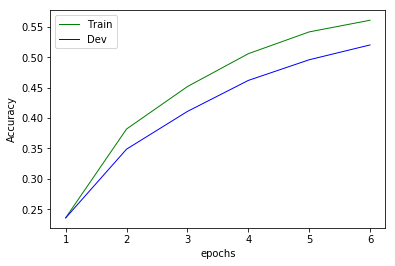

In [32]:
lr.plot_train(train_acc, dev_acc)

## Rosenblatt Perceptron:
Now that we have seen the logistic regression example (which is the hardest one), you will have to implement the Rosenblatt Perceptron.

Remember that the only thing that is different from this classifier to the Logistic Regression example is the update rule of the weights, that when the predicted label $\hat{y}$ is not correct $\hat{y} \neq y$ follows the following rule:

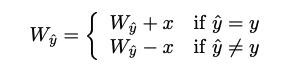

Which basically states that we have to add to the "correct" class parameters $W_y$ the input features $x$ and decrement to the incorrectly predicted class parameters $W_{\hat{y}}$ the input features $x$.


In terms of prediction the Rosenblatt preceptron follows the following expression:

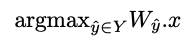

<!---
    def predict(self, x):
        return np.argmax(np.dot(np.append(x, [1]), self.parameters))

    def update_weights(self, x, y):
        y_pred = self.predict(x)
        if y != y_pred:
            self.parameters[:, y] += np.append(x, [1])
            self.parameters[:, y_pred] -=  np.append(x, [1])
-->


In [20]:
class MultiClassPerceptron(Classifier):
    """ Multi Class Perceptron """

    def __init__(self, input_size, n_classes):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        Classifier.__init__(self, input_size, n_classes)

    def predict(self, x):
        """
        This function will add a Bias value to the received input, multiply the Weights 
            corresponding to the different classes with the input vector and choose the class 
            that maximizes that multiplication.
        :param x: numpy array with size 1xN where N = number of features.
        """
        # your code here

    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will update the 
            model parameters.
        :param x: Array of size N where N its the number of features that the model takes as input.
        :param y: The int corresponding to the correct label.
        """
        # your code here
        

In [21]:
perceptron = MultiClassPerceptron(X.shape[1], len(np.unique(Y)))

In [ ]:
perceptron.parameters.shape

In [ ]:
train_acc, dev_acc = perceptron.train(X, Y, devX=X_test, devY=Y_test, epochs=5)

In [ ]:
perceptron.plot_train(train_acc, dev_acc)